## Behavior Cloning Project

In [1]:
import os
import csv

from keras.models import Sequential, Model
from keras.layers import Cropping2D, Lambda, Dense, Conv2D, Activation, Flatten, MaxPooling2D, Dropout
from sklearn.model_selection import train_test_split
from random import shuffle
import cv2
import numpy as np
import sklearn

Using TensorFlow backend.


## Read Driving log

In [2]:
samples = []
with open('./driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

## Train - Validation split

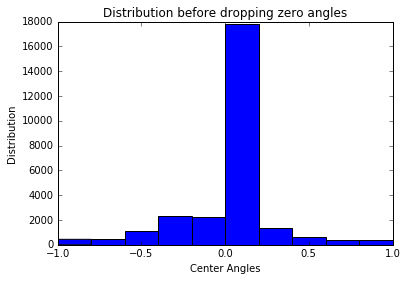

Length of samples = 27174
Length of samples new = 16223


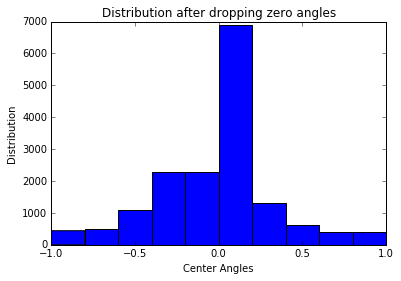

Number of training samples = 12978
Number of validation samples = 3245


In [24]:
import matplotlib.pyplot as plt
import random


retain_probability = 0.33

# Plot histogram - before dropping zero angles
center_angles_before = np.array([item[3] for item in samples]).astype(float)

plt.xlabel('Center Angles')
plt.ylabel('Distribution')
plt.title('Distribution before dropping zero angles')
plt.hist(center_angles_before)
plt.show()

print("Length of samples = " + str(len(samples)))

# Eliminate 67% of the zero angles
samples_new = [item for item in samples if ((random.random() <= retain_probability and float(item[3]) == 0) 
                                            or float(item[3]) != 0)]

print("Length of samples new = " + str(len(samples_new)))

center_angles_after = np.array([item[3] for item in samples_new]).astype(float)

plt.xlabel('Center Angles')
plt.ylabel('Distribution')
plt.title('Distribution after dropping zero angles')
plt.hist(center_angles_after)
plt.show()

train_samples, validation_samples = train_test_split(samples_new, test_size=0.2)

print("Number of training samples = " + str(len(train_samples)))
print("Number of validation samples = " + str(len(validation_samples)))


## Data Augmentation - Image Transformations

In [25]:
def crop_image(img):
    return img[50:-20, :, :]
    

def resize_image(img):
    return cv2.resize(img, (200, 66), cv2.INTER_AREA)
    
def translate_image(img):    
    rows,cols,channel = img.shape
    trans_range = 20
    tx =  np.random.randint(-1*trans_range, trans_range)
    ty =  np.random.randint(-1*trans_range, trans_range)

    M = np.float32([[1,0,tx],[0,1,ty]])
    dst = cv2.warpAffine(img,M,(cols,rows))
    return dst

def flip_image(img):
    return cv2.flip(img, 1)

def increase_contrast(img):
    clahe = cv2.createCLAHE(clipLimit=3., tileGridSize=(8,8))
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)  # convert from BGR to LAB color space
    l, a, b = cv2.split(lab)  # split on 3 different channels
    l2 = clahe.apply(l)  # apply CLAHE to the L-channel
    lab = cv2.merge((l2,a,b))  # merge channels
    img2 = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)  # convert from LAB to BGR
    return img2

def transform(img):
    transforms = [translate_image, flip_image, increase_contrast]
    for idx in range(len(transforms)):
        img = transforms[idx](img)
    return img

## Generator will stream training sampeles while training

In [26]:
import matplotlib.pyplot as plt
import matplotlib

def generator(samples, batch_size=32):
    
    global vis_num_images
    global img_count
    
    num_samples = len(samples)
    correction = 0.2
    transform_probability = 0.25
  
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                
                # Center
                name = './IMG/'+batch_sample[0].split('/')[-1]
                center_image = cv2.imread(name)
                center_image = crop_image(center_image)
                center_image = resize_image(center_image)
                center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2YUV)

                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)

                # Left
                name = './IMG/' + batch_sample[1].split('/')[-1]
                left_image = cv2.imread(name)
                left_image = crop_image(left_image)
                left_image = resize_image(left_image)
                left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2YUV)

                images.append(left_image)

                # Left correction
                left_angle = center_angle + correction
                angles.append(left_angle)

                # Right
                name = './IMG/' + batch_sample[2].split('/')[-1]
                right_image = cv2.imread(name)
                right_image = crop_image(right_image)
                right_image = resize_image(right_image)
                right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2YUV)
                
                images.append(right_image)

                # Right correction
                right_angle = center_angle - correction
                angles.append(right_angle)
                
                # Randomly transform about x% of the images and augment the existing data set
                
                if random.random() <= transform_probability:
                    # Randomly choose center, left or right image for transformations
                    
                    choice = random.randint(0, 2)
                    
                    # Center
                    if choice == 0:
                        center_image = transform(center_image)
                        # Changing the angle as we flipped the image in transformations
                        center_angle *= -1
                        
                        if img_count <= vis_num_images:
                            plt.imshow(center_image)
                            plt.show()
                            img_count += 1
                  
                    images.append(center_image)
                    angles.append(center_angle)
                    
                    # Left
                    if choice == 1:
                        left_image = transform(left_image)
                        left_angle *= -1
                        
                        if img_count <= vis_num_images:
                            plt.imshow(left_image)
                            plt.show()
                            img_count += 1
                            
                    images.append(left_image)
                    angles.append(left_angle)
                    
                    # Right
                    if choice == 2:
                        right_image = transform(right_image)
                        right_angle *= -1
                        
                        if img_count <= vis_num_images:
                            plt.imshow(right_image)
                            plt.show()
                            img_count += 1
                            
                    images.append(right_image)
                    angles.append(right_angle)     
                
            X_train = np.array(images)
            y_train = np.array(angles)
            
            
           
            yield sklearn.utils.shuffle(X_train, y_train)

In [27]:
# compile and train the model using the generator function

# Global - just for visualizing transformed images
vis_num_images = 20
img_count = 0

train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

## Model Architecture

Epoch 1/12


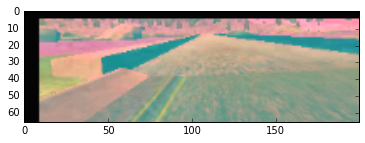

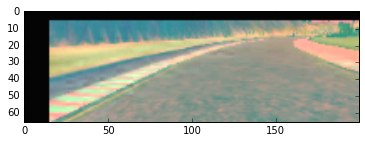

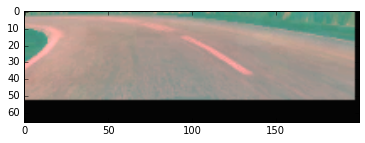

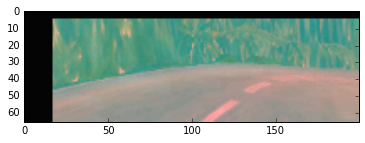

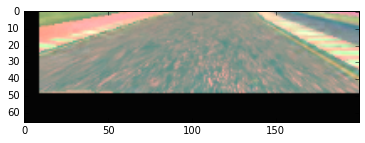

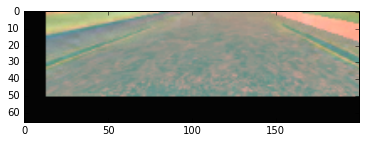

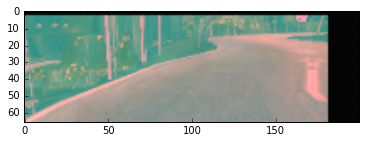

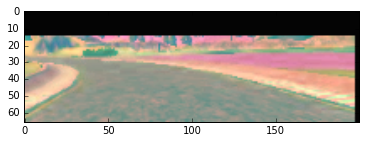

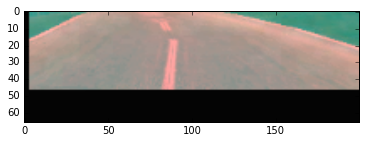

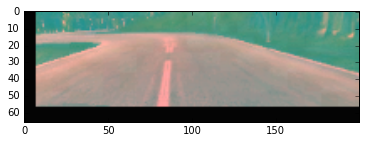

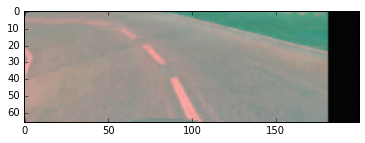

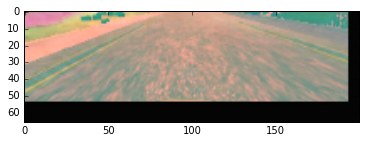

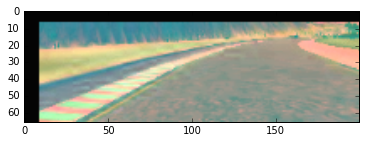

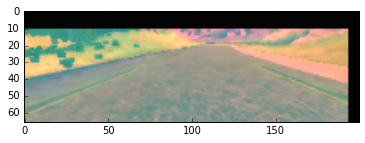

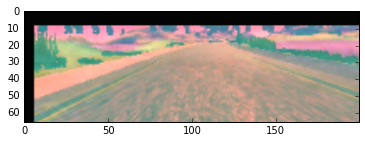

  1/405 [..............................] - ETA: 1155s - loss: 0.2784

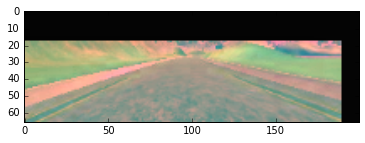

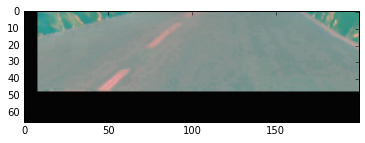

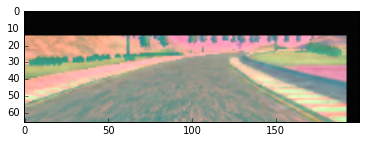

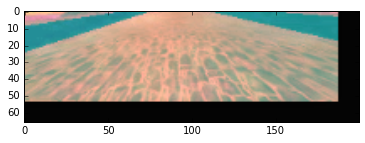

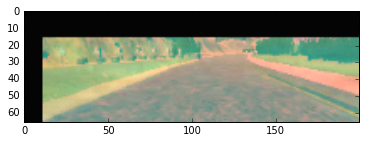

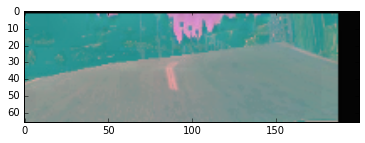

239/405 [================>.............] - ETA: 128s - loss: 0.0982

In [ ]:
from keras.callbacks import ModelCheckpoint
import keras
from keras import regularizers
from keras import optimizers
from keras import backend as K


ch, row, col = 3, 66, 200  # Resized image
batch_size = 32

# set up cropping2D layer
model = Sequential()

# Layer 1 - Pre-processing Layer - Normalization
model.add(Lambda(lambda x: x/127.5 - 1.,
        input_shape=(row, col, ch)))

# Layer 2 - Conv 1
model.add(Conv2D(32, (5,5), padding = 'same'))
model.add(Activation('relu'))

# Layer 3 - Conv 2
model.add(Conv2D(32, (5,5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Layer 4 - Conv 3
model.add(Conv2D(48, (5,5), padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Layer 5 - Conv 4
model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Layer 6 - Conv 5
model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Layer 7 - Flatten
model.add(Flatten())

# Layer 8 - FC - 1
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.3))

# Layer 9 - FC - 2
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Layer 10 - FC - 3
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
          
# Layer 11 - Dense final output layer
model.add(Dense(1))

#adam_opt = optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#model.compile(loss='mse', optimizer=adam_opt)

model.compile(loss='mse', optimizer='adam')

filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='min')
callbacks_list = [checkpoint]


history_object = model.fit_generator(train_generator, 
                    steps_per_epoch = len(train_samples) // batch_size, 
                    validation_data=validation_generator,
                    validation_steps=len(validation_samples) // batch_size,
                    callbacks = callbacks_list,
                    epochs=12)

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 66, 200, 32)       2432      
_________________________________________________________________
activation_17 (Activation)   (None, 66, 200, 32)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 62, 196, 32)       25632     
_________________________________________________________________
activation_18 (Activation)   (None, 62, 196, 32)       0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 31, 98, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 31, 98, 32)        0         
__________

Epoch 1/12


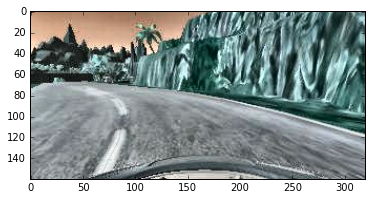

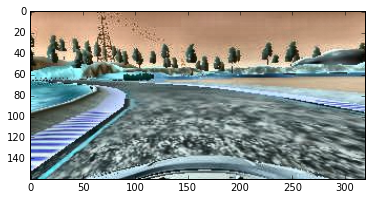

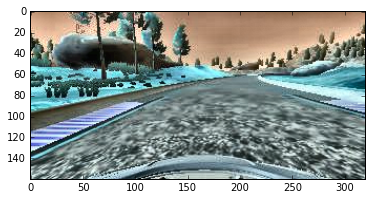

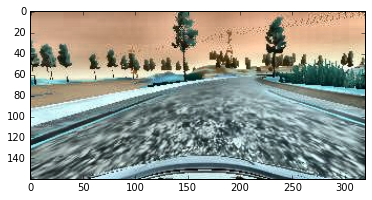

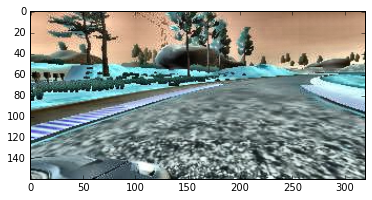

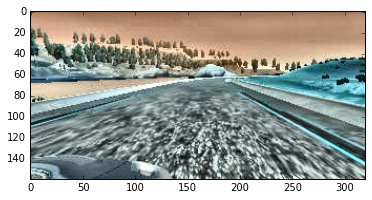

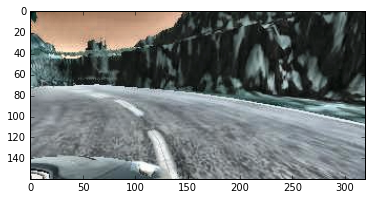

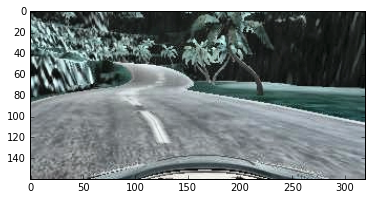

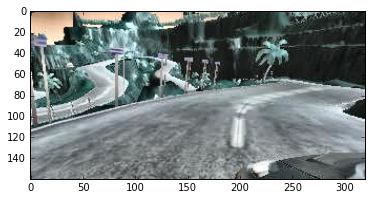

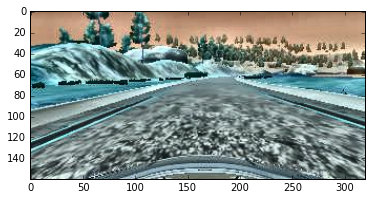

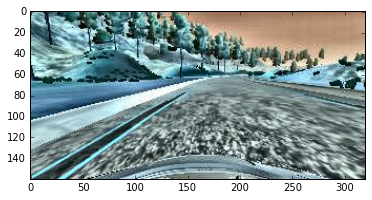

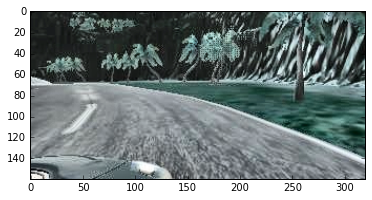

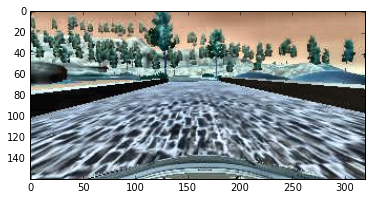

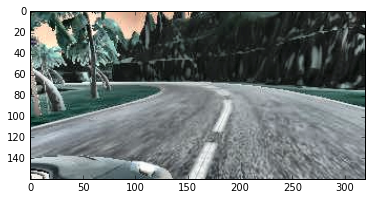

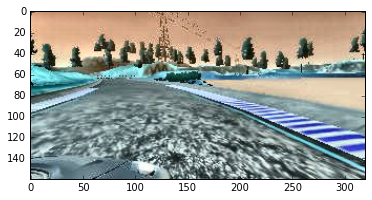

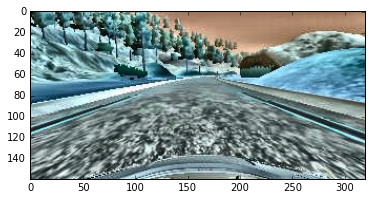

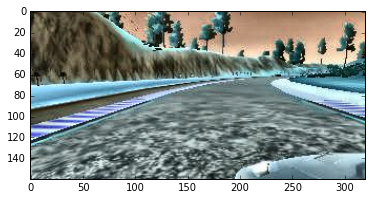

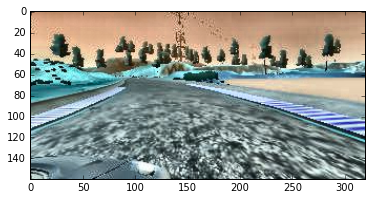

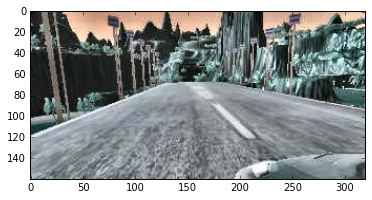

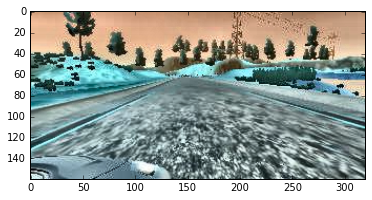

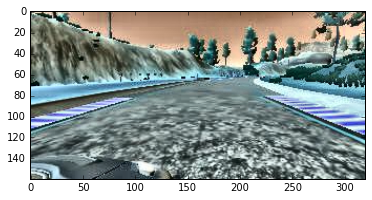

 16/406 [>.............................] - ETA: 778s - loss: 2.6757

KeyboardInterrupt: 

In [7]:
from keras.callbacks import ModelCheckpoint
import keras
from keras import regularizers


ch, row, col = 3, 80, 320  # Trimmed image format
batch_size = 32

# set up cropping2D layer
model = Sequential()

# Layer 1 - Cropping Layer

model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160, 320, 3)))

# Preprocess incoming data, centered around zero with small standard deviation 

# Layer 2 - Pre-processing Layer
model.add(Lambda(lambda x: x/127.5 - 1.,
        input_shape=(row, col, ch),
        output_shape=(row, col, ch)))

# Layer 3 - Conv 1
model.add(Conv2D(32, (5,5), padding = 'same'))
model.add(keras.layers.ELU(alpha=1.0))

# Layer 4 - Conv 2
model.add(Conv2D(32, (5,5), kernel_regularizer=regularizers.l2(0.01)))
model.add(keras.layers.ELU(alpha=1.0))
model.add(MaxPooling2D(pool_size=(2,2)))

# Layer 5 - Conv 3
model.add(Conv2D(64, (5,5), padding = 'same', kernel_regularizer=regularizers.l2(0.01)))
model.add(keras.layers.ELU(alpha=1.0))
model.add(MaxPooling2D(pool_size=(2,2)))

# Layer 6 - Conv 4
model.add(Conv2D(64, (3,3), kernel_regularizer=regularizers.l2(0.01)))
model.add(keras.layers.ELU(alpha=1.0))
model.add(MaxPooling2D(pool_size=(2,2)))

# Layer 7 - Conv 5
model.add(Conv2D(64, (3,3), kernel_regularizer=regularizers.l2(0.01)))
model.add(keras.layers.ELU(alpha=1.0))
model.add(MaxPooling2D(pool_size=(2,2)))
          
# Layer 8 - Flatten
model.add(Flatten())

# Layer 9 - FC - 1
model.add(Dense(512))
model.add(keras.layers.ELU(alpha=1.0))

# Layer 10 - FC - 2
model.add(Dense(256))
model.add(keras.layers.ELU(alpha=1.0))

# Layer 11 - FC - 3
model.add(Dense(128))
model.add(keras.layers.ELU(alpha=1.0))

# Layer 12 - Dense final output layer
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='min')
callbacks_list = [checkpoint]


history_object = model.fit_generator(train_generator, 
                    steps_per_epoch = len(train_samples) // batch_size, 
                    validation_data=validation_generator,
                    validation_steps=len(validation_samples) // batch_size,
                    callbacks = callbacks_list,
                    epochs=12)

## Training vs Validation Loss

In [ ]:
model.save('model.h5')

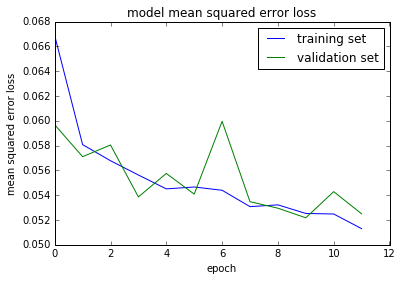

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()